<a href="https://colab.research.google.com/github/nataliaespector/CEIA_TPs_Procesamiento_Lenguaje_Natural_1/blob/main/Espector_PLN_Desafio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Procesamiento de Lenguaje Natural I - Desafío 2

## 1 - Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.

Para este desafío se utilizará el mismo dataset de canciones visto en clase, pero en lugar de trabajar con canciones de los Beatles, se analizarán canciones de Bob Dylan.

Se importan las librerías necesarias:

In [234]:
%pip install numpy scikit-learn gensim

In [235]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

Se descarga el dataset de canciones de bandas de habla inglesa:

In [236]:
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


Se listan las posibles bandas/músicos:

In [237]:
os.listdir("./songs_dataset/")

['adele.txt',
 'beatles.txt',
 'bieber.txt',
 'leonard-cohen.txt',
 'dj-khaled.txt',
 'alicia-keys.txt',
 'kanye.txt',
 'missy-elliott.txt',
 'cake.txt',
 'kanye-west.txt',
 'lin-manuel-miranda.txt',
 'michael-jackson.txt',
 'joni-mitchell.txt',
 'lil-wayne.txt',
 'bruno-mars.txt',
 'ludacris.txt',
 'eminem.txt',
 'jimi-hendrix.txt',
 'radiohead.txt',
 'paul-simon.txt',
 'dolly-parton.txt',
 'janisjoplin.txt',
 'notorious-big.txt',
 'bjork.txt',
 'bob-dylan.txt',
 'johnny-cash.txt',
 'dickinson.txt',
 'Kanye_West.txt',
 'amy-winehouse.txt',
 'prince.txt',
 'notorious_big.txt',
 'drake.txt',
 'britney-spears.txt',
 'bruce-springsteen.txt',
 'dr-seuss.txt',
 'nursery_rhymes.txt',
 'r-kelly.txt',
 'blink-182.txt',
 'patti-smith.txt',
 'nicki-minaj.txt',
 'nickelback.txt',
 'bob-marley.txt',
 'Lil_Wayne.txt',
 'disney.txt',
 'lorde.txt',
 'nirvana.txt',
 'lady-gaga.txt',
 'rihanna.txt',
 'al-green.txt']

Se arma un dataframe con las canciones de Bob Dylan, separado por salto de línea (cada fila será una línea de una canción):

In [238]:
df = pd.read_csv('songs_dataset/bob-dylan.txt', sep='/n', header=None)
df.head()

/tmp/ipython-input-3962476315.py:1: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



,0
0,"“There must be some way out of here,” said the..."
1,"“There’s too much confusion, I can’t get no re..."
2,"Businessmen, they drink my wine, plowmen dig m..."
3,None of them along the line know what any of i...
4,"“No reason to get excited,” the thief, he kind..."


In [239]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 5213


Preprocesamiento: se utiliza text_to_word_sequence para separar en palabras:

In [240]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones en una secuencia de palabras
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

Verificación:

In [241]:
sentence_tokens[:2]

[['“there',
  'must',
  'be',
  'some',
  'way',
  'out',
  'of',
  'here',
  '”',
  'said',
  'the',
  'joker',
  'to',
  'the',
  'thief'],
 ['“there’s', 'too', 'much', 'confusion', 'i', 'can’t', 'get', 'no', 'relief']]

Modificación de callback para informar loss en cada época:

In [242]:
from gensim.models.callbacks import CallbackAny2Vec

class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

Se utilizará el modelo Word2Vec con Skipgram para crear los vectores:

In [243]:
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

Obtener vocabulario con los tokens:

In [244]:
w2v_model.build_vocab(sentence_tokens)

Cantidad de filas/documentos encontrados en el corpus:

In [245]:
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 5213


Cantidad de palabras distintas encontradas en el corpus:

In [246]:
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 948


Entrenar el modelo generador de vectores:

In [247]:
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=100,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 291516.65625
Loss after epoch 1: 185722.1875
Loss after epoch 2: 189597.78125
Loss after epoch 3: 187643.0625
Loss after epoch 4: 187074.9375
Loss after epoch 5: 160502.875
Loss after epoch 6: 157903.125
Loss after epoch 7: 154055.625
Loss after epoch 8: 150566.875
Loss after epoch 9: 145901.25
Loss after epoch 10: 143920.0
Loss after epoch 11: 140456.875
Loss after epoch 12: 124449.0
Loss after epoch 13: 121068.75
Loss after epoch 14: 119576.25
Loss after epoch 15: 118504.75
Loss after epoch 16: 117808.5
Loss after epoch 17: 117127.5
Loss after epoch 18: 113734.75
Loss after epoch 19: 116168.5
Loss after epoch 20: 113913.0
Loss after epoch 21: 111499.0
Loss after epoch 22: 111207.75
Loss after epoch 23: 110870.75
Loss after epoch 24: 108163.5
Loss after epoch 25: 109369.75
Loss after epoch 26: 109354.0
Loss after epoch 27: 107165.25
Loss after epoch 28: 107664.75
Loss after epoch 29: 106450.25
Loss after epoch 30: 103771.75
Loss after epoch 31: 99905.5
Loss after e

(2216546, 3841500)

## 2 - Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras, similitudes y diferencias).

Se eligen como términos de interés algunas palabras que se sabe que están incluidas en las canciones de Bob Dylan y que son muy utilizadas, por estar en el título o en el estribillo de algunas canciones: *door, song, wind, stone*. Se analizan las 10 palabras más similares de las primeras 3, y las 10 menos similares de la última:

In [248]:
w2v_model.wv.most_similar(positive=["door"], topn=10)

[('knock', 0.5437401533126831),
 ('knockin’', 0.5229071378707886),
 ('heaven’s', 0.5223445296287537),
 ('gate', 0.5201696157455444),
 ('bend', 0.4484601616859436),
 ('shut', 0.4399539530277252),
 ('darkness', 0.4245995581150055),
 ('blade', 0.42352378368377686),
 ('window', 0.4198409914970398),
 ('ears', 0.4079689085483551)]

Palabras más similares a "door": se obtienen las palabras que era lógico encontrar, dado que se utilizó para el entrenamiento la canción *"Knockin' on heaven's door"*. Esto muestra que el modelo está funcionando como se esperaba.

Las primeras 3 palabras no son similares en su significado, pero sí suelen aparecer juntas. Luego se observan otras palabras cuyo significado sí está relacionado a *'door'*, tales como *'gate'*, *'shut'* y *'window'*.

In [249]:
w2v_model.wv.most_similar(positive=["song"], topn=10)

[('tambourine', 0.6224939227104187),
 ('hey', 0.5756471753120422),
 ('lover', 0.53081214427948),
 ('mr', 0.5260533690452576),
 ('call', 0.48345085978507996),
 ('singin’', 0.4809739887714386),
 ('warm', 0.47836026549339294),
 ('fit', 0.4735334813594818),
 ('you—now', 0.470608115196228),
 ('gate', 0.46139422059059143)]

Palabras más similares a "song": como en el caso anterior, obtenemos las palabras que se esperaban, considerando la letra de la canción que repite varias veces *"Hey Mr Tambourine man, play a song for me"*. En el listado vemos además la palabra *"singin"*, relacionada en su significado, y que suele encontrarse en contextos similares.

In [250]:
w2v_model.wv.most_similar(positive=["wind"], topn=10)

[('answer', 0.5279859304428101),
 ('north', 0.4400685131549835),
 ('blowin’', 0.4353673756122589),
 ('blows', 0.43473386764526367),
 ('hope', 0.4289775788784027),
 ('angel', 0.4170595109462738),
 ('ancient', 0.4077379107475281),
 ('tangled', 0.40716665983200073),
 ('daddy’s', 0.404609352350235),
 ('blow', 0.39545243978500366)]

Palabras más similares a "wind": también se obtienen palabras esperadas, que surgen de la letra que se repite *"the answer, my friend, is blowin' in the wind"*. Se observa que aparece una misma palabra en distintas formas: *"blowin'", "blows"* y *"blow"*, que no provienen de la misma canción, pero sí están claramente relacionadas entre sí y con la palabra *"wind"*.

In [251]:
w2v_model.wv.most_similar(negative=["stone"], topn=10)

[('any', -0.011665698140859604),
 ('take', -0.03180922940373421),
 ('called', -0.04023498669266701),
 ('one', -0.056366804987192154),
 ('talk', -0.0666089653968811),
 ('were', -0.07009243965148926),
 ('this', -0.07250683754682541),
 ('kingdom', -0.07258763909339905),
 ('where', -0.07493628561496735),
 ('nobody', -0.07572993636131287)]

Palabras **menos** similares a "stone": se obtienen palabras variadas, cuyo significado no está relacionado con *"stone"*, y que tampoco se encuentran en la canción *"Like a rollin' stone"* (al menos en el estribillo, donde podrían estar las palabras más cercanas a *"stone"*).

Se prueba con una palabra que no está presente en el vocabulario, sólo para comprobar que no puede analizarse utilizando esta metodología y que se obtiene un error:

In [252]:
w2v_model.wv.most_similar(negative=["guitar"])

KeyError: "Key 'guitar' not present in vocabulary"

## 3 - Graficarlos y obtener conclusiones

Se aplica una reducción de dimensiones a los embeddings con t-SNE, para poder hacer gráficos en 2D y 3D, y visualizar en forma gráfica las relaciones entre palabras:

In [253]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

Gráfico en 2D:

In [254]:
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

Para que el gráfico se pueda visualizar correctamente se eligen 200 palabras.

Se puede observar que los términos *"god", "believe"* y *"lord"* son cercanos.

Sin embargo, en este caso resulta difícil observar relaciones entre los términos, probablemente porque la reducción de dimensionalidad es demasiada y estamos perdiendo información.

Gráfico en 3D:

In [255]:
vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

En este gráfico alcanzamos a ver algunas relaciones más, tales como *"like"* y *"stone"*. De todas formas, resulta difícil encontrar relaciones con esta visualización. Además, al mostrar sólo 200 palabras observando poca información.

A continuación, se guardan los vectores y labels como .tsv para graficar en http://projector.tensorflow.org/

La visualización resulta mejor, ya que permite ver todas las palabras e ir seleccionando cada una para ver las más relacionadas. Además, permite hacer la reducción de dimensionalidad con distintos métodos.

Se muestra una captura de pantalla para ejemplificar el gráfico obtenido en Embedding Projector para la palabra *"song"*, en este caso utilizando PCA en lugar de t-SNE:

In [256]:
vectors = np.asarray(w2v_model.wv.vectors)
labels = list(w2v_model.wv.index_to_key)

np.savetxt("vectors.tsv", vectors, delimiter="\t")

with open("labels.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)

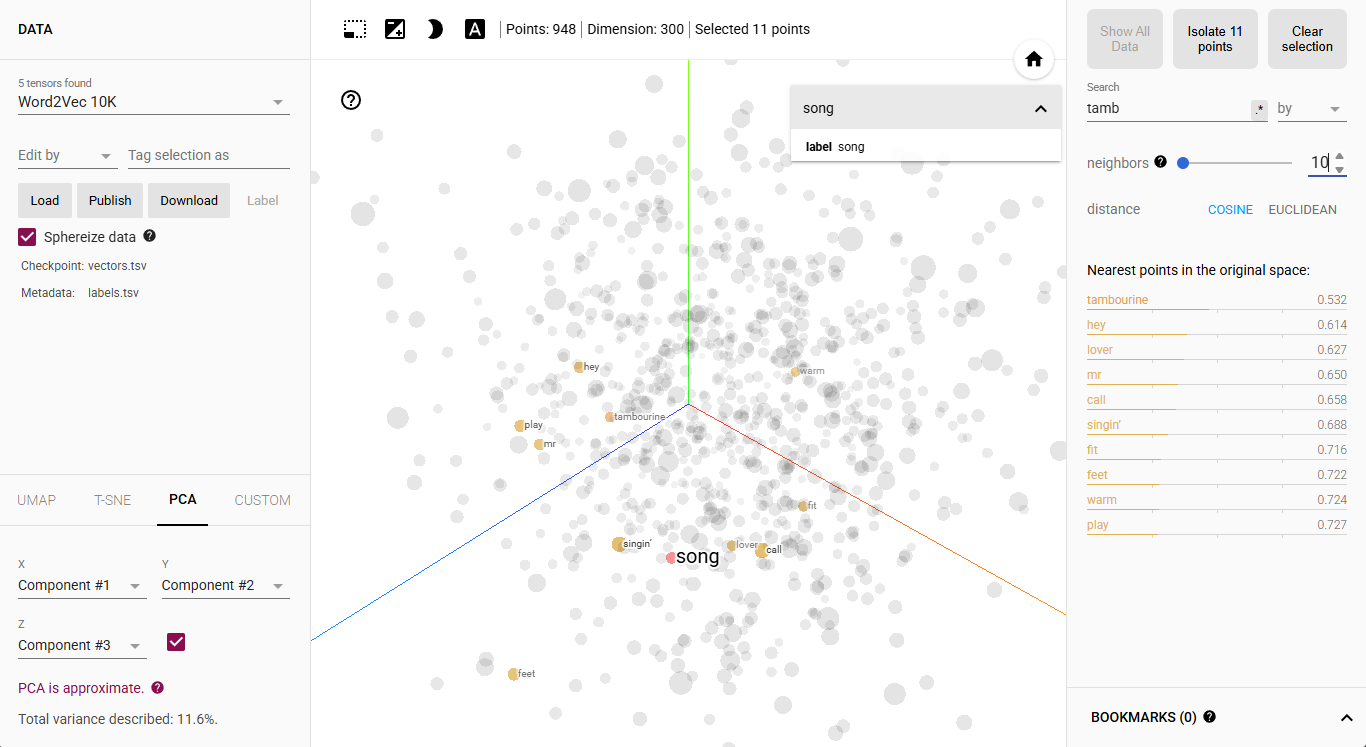

Se observa que las palabras obtenidas como más similares habiendo aplicado PCA son prácticamente las mismas que se habían encontrado antes, con una leve diferencia en el orden.